In [1]:
from FusekiCommunicator import FusekiCommunicatior
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, Dict
from pydantic import BaseModel
from rdflib import Graph, URIRef, Literal, BNode

class ResponseHead(BaseModel):
    vars: list[str]

class ResponseResults(BaseModel):
    bindings: list[Dict[str, Any]]

class SearchResponse(BaseModel):
    head: ResponseHead
    results: ResponseResults
    
from starlette.responses import RedirectResponse
from starlette.status import (
    HTTP_303_SEE_OTHER,
    HTTP_400_BAD_REQUEST,
    HTTP_500_INTERNAL_SERVER_ERROR,
)
from fastapi import APIRouter, HTTPException
from loguru import logger

import datetime

In [2]:
triple_type = {
    'uri': URIRef,
    'literal': Literal,
    'bnode': BNode
}

We are going to run some simulations to compare how many triples one needs to store in different scenarios.
We are going to look at $\Delta_{n,0}$ and $\Delta_{n,n-1}$ scenarios. Also, one has to look at a scheme where for the latter we need to store *two* full graphs instead of one for the former scheme.

Below we define Fuseki of the local **LSL** cluster where we will store the data:

In [3]:
fuseki_jena_url = "192.168.4.26"
fuseki_jena_port = "30731"
fuseki_jena_dataset_name = "slice"
fuseki = FusekiCommunicatior(
    fuseki_jena_url, fuseki_jena_port, fuseki_jena_dataset_name
)

Here we define the Fuseki of the **Integration cluster** from which we obtain the data:

In [4]:
fuseki_jena_url_integration = "jena-fuseki.integration"
fuseki_jena_port_integration = None
fuseki_jena_dataset_name_integration = "slice"
fuseki_integration = FusekiCommunicatior(
    fuseki_jena_url_integration, fuseki_jena_port_integration, fuseki_jena_dataset_name_integration
)

In [5]:
def read_file(fname):
    with open(fname, "r") as f:
        return f.read()

def perform_query(query, fuseki):
    valid, msg = fuseki.validate_sparql(query, "query")
    if valid:
        result = fuseki.read_query(query)
        bindings = []
        for item in result.bindings:
            new_item: Dict[str, Any] = {}
            for key in item:
                new_item[key] = {}
                for property in item[key].__dict__:
                    if (
                        property != "variable"
                        and item[key].__dict__[property] is not None
                    ):
                        new_item[key][property] = item[key].__dict__[property]
                        if property == "lang":
                            new_item[key]["xml:lang"] = new_item[key].pop("lang")
            bindings.append(new_item)
        return SearchResponse(
                head=ResponseHead(vars=result.head["vars"]),
                results=ResponseResults(bindings=bindings),
            )
    print(msg)
    return None

In [6]:
timestamps_integration = np.array(
    [
        timestamp["graphURI"]["value"]
        for timestamp in perform_query(
            read_file("query_timestamps.txt"), fuseki_integration
        ).results.bindings
    ]
)
print(f"{timestamps_integration.size} timestamps retrieved.")

print("Getting the size of the named graphs.")
graph_sizes = []
for i in range(timestamps_integration.size):
    print(f"{i/(timestamps_integration.size-1)*100:.2f}%", end="\r")
    # graph_sizes.append(number_of_triples(timestamps[i]))
graph_sizes = np.array(graph_sizes)

293 timestamps retrieved.
Getting the size of the named graphs.


In [ ]:
timestamps_integration = [
        timestamp["graphURI"]["value"]
        for timestamp in perform_query(
            read_file("query_timestamps.txt"), fuseki_integration
        ).results.bindings
    ]


In [7]:
timestamps_integration[0]

np.str_('timestamp:1731315005935')

In [8]:
local_time = datetime.datetime.fromtimestamp(int(timestamps_integration[-1].split(":")[-1])//1000)
print(f"Local time: {local_time}")

Local time: 2024-11-13 10:40:17


In [9]:
def get_graph_from_bindings(bindings):
    g = Graph()

    for binding in bindings: #response.results.bindings:
        g.add((triple_type[binding['s']['type']](binding['s']['value']), triple_type[binding['p']['type']](binding['p']['value']), triple_type[binding['o']['type']](binding['o']['value'])))
    
    return g

In [10]:
def read_graph_from_time_stamp(timestamp, a_fuseki):
    fname = "simple_query.txt"

    query = read_file(fname).replace("graph1", timestamp)
    response = perform_query(query, a_fuseki)
    g = get_graph_from_bindings(response.results.bindings)

    return g

In [12]:
def compose_insert_query_form_graph(g: Graph, graph_name: str) -> str:
    n_triples = 0
    query = "INSERT DATA {\n"
    query += "\tGRAPH <" + graph_name + "> {\n"  # "\tGRAPH <timestamp:%d> {\n" % ts
    for s, p, o in g.triples((None, None, None)):
        if hasattr(s, "n3") and hasattr(p, "n3") and hasattr(o, "n3"):
            query += f"\t\t{s.n3()} {p.n3()} {o.n3()} .\n"
            n_triples += 1
        else:
            raise HTTPException(
                HTTP_500_INTERNAL_SERVER_ERROR, "Error in parsing JSON-LD."
            )
    query += "\t}\n"
    query += "}"

    valid, msg = fuseki.validate_sparql(query, "update")
    
    # return query, valid, msg
    if n_triples == 0:
        logger.error("No triples could be extracted from Graph")
        raise HTTPException(
            HTTP_400_BAD_REQUEST, "No triples could be extracted from Graph."
        )
        
    elif valid:
        logger.debug(f"Return query with {n_triples} triple(s) and name {graph_name}.")
        return query        
    else:
        logger.error(msg)
        logger.debug(f"The query:\n{query}")
        raise HTTPException(HTTP_500_INTERNAL_SERVER_ERROR, msg)



In [15]:
# this can be the basis for the reconstruction function

g0 = read_graph_from_time_stamp(timestamps_integration[0],fuseki_integration)
g1 = read_graph_from_time_stamp(timestamps_integration[0],fuseki_integration)

size_graph_g = []
size_deltas_n_0 = []
size_deltas_n_n1 = []

for timestamp in timestamps_integration[1:]:
    local_time = datetime.datetime.fromtimestamp(int(timestamp.split(":")[-1])//1000)
    print(f"Timestamp time: {local_time}", end='\r')
    # print(timestamp, end='\r')
    
    g = read_graph_from_time_stamp(timestamp, fuseki_integration)
    
    size_graph_g.append(len(g))

    delta_plus_n_0 = g-g0
    delta_minus_n_0 = g0-g
    
    size_deltas_n_0.append(len(delta_plus_n_0) + len(delta_minus_n_0))

    delta_plus_n_n1 = g-g1
    delta_minus_n_n1 = g1-g
    
    size_deltas_n_n1.append(len(delta_plus_n_n1) + len(delta_minus_n_n1))
    
    g1=g


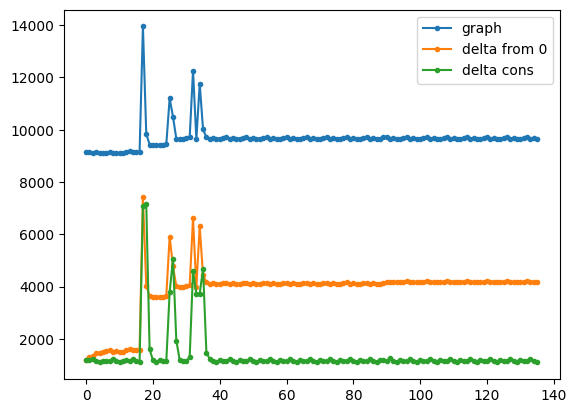

In [16]:
size_graph_g=np.array(size_graph_g)
size_deltas_n_0=np.array(size_deltas_n_0)
size_deltas_n_n1=np.array(size_deltas_n_n1)

plt.plot(size_graph_g, '.-', label='graph')
plt.plot(size_deltas_n_0, '.-', label='delta from 0')
plt.plot(size_deltas_n_n1+0*np.mean(size_graph_g), '.-', label='delta cons')

plt.legend()

In [18]:
np.mean(size_deltas_n_n1[-20:])

np.float64(1154.7)

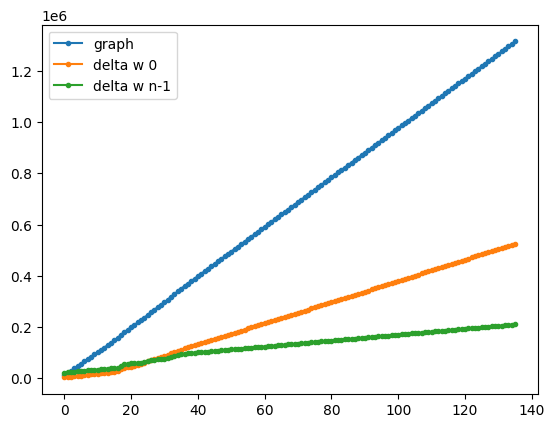

In [19]:
plt.plot(np.cumsum(size_graph_g),'.-', label='graph')
plt.plot(np.cumsum(size_deltas_n_0),'.-', label='delta w 0')
plt.plot(np.cumsum(size_deltas_n_n1)+2*np.mean(size_graph_g),'.-', label='delta w n-1')

plt.legend()

# add real time to the x-axis
# add future projections using linear trends for orange and green as to when they will reach the critical capacity
# critical capacity can be estimated as 2500*9000 triples (or even 3000)

In [31]:
timestamps_integration = np.array(
    [
        timestamp["graphURI"]["value"]
        for timestamp in perform_query(
            read_file("query_timestamps.txt"), fuseki_integration
        ).results.bindings
    ]
)
print(f"{timestamps_integration.size} timestamps retrieved.")

local_time = datetime.datetime.fromtimestamp(int(timestamps_integration[-1].split(":")[-1])//1000)
print(f"Local time: {local_time}")

145 timestamps retrieved.
Local time: 2024-11-12 10:00:06


In [21]:
timestamps = np.array(
    [
        timestamp["graphURI"]["value"]
        for timestamp in perform_query(
            read_file("query_timestamps.txt"), fuseki
        ).results.bindings
    ]
)
print(f"{timestamps.size} timestamps retrieved.")

0 timestamps retrieved.


In [22]:
def count_time_steps_on_lsl_server():
    timestamps = np.array(
        [
            timestamp["graphURI"]["value"]
            for timestamp in perform_query(
                read_file("query_timestamps.txt"), fuseki
            ).results.bindings
        ]
    )
    
    return timestamps.size, timestamps #?

In [75]:
def find_temp(timestamps):
    
    for timestamp in timestamps:
        if 'temp' in timestamp:
            return timestamp
    return 'none'

In [76]:
def find_base(timestamps):
    
    for timestamp in timestamps:
        if 'base' in timestamp:
            return timestamp
    return 'none base'

In [77]:
def write_timestamp_to_database(timestamp):

    # read graph for the input
    g = read_graph_from_time_stamp(timestamp, fuseki_integration)
    # check how many graphs are there on the LSL server and what are they
    time_steps_on_LSL, timestamps_LSL = count_time_steps_on_lsl_server()

    # if there are no graphs yet
    if time_steps_on_LSL == 0:
        # write the very first graph with a suffix /base
        query_g_0 = compose_insert_query_form_graph(g, timestamp + "/base")
        fuseki.update_query(query_g_0)
    # if there is just one
    elif time_steps_on_LSL == 1:
        # here is the case for the first deltas

        # reading the base graph to use in delta computation
        g0 = read_graph_from_time_stamp(timestamps_LSL[0], fuseki)
        # compute the added and removed graphs
        delta_plus = g - g0
        delta_minus = g0 - g

        # compose a query for added
        query_plus = compose_insert_query_form_graph(
            delta_plus, timestamp + "/added"
        )
        # compose a query for removed
        query_minus = compose_insert_query_form_graph(
            delta_minus, timestamp + "/removed"
        )

        # write added to LSL fuseki
        fuseki.update_query(query_plus)
        # write removed to LSL fuseki
        fuseki.update_query(query_minus)
        
        
        query_temp = compose_insert_query_form_graph(
            g, timestamp + "/temp"
        )
        
        fuseki.update_query(query_temp)

    else:
        # here is the most common case
        # find where the previous time stamp is completely (temporarily) stored
        timestamp_previous = find_temp(timestamps_LSL)
        # read the previous (n-1) time stamp
        g0 = read_graph_from_time_stamp(timestamp_previous, fuseki)
        
        # compute deltas
        delta_plus = g - g0
        delta_minus = g0 - g
        
        # compose a query for added
        query_plus = compose_insert_query_form_graph(
            delta_plus, timestamp + "/added"
        )
        # compose a query for removed
        query_minus = compose_insert_query_form_graph(
            delta_minus, timestamp + "/removed"
        )

        # write added to LSL fuseki
        fuseki.update_query(query_plus)
        # write removed to LSL fuseki
        fuseki.update_query(query_minus)
        
        #remove previous temp graph
        query_delete = f"DROP GRAPH <{timestamp_previous}>" 
        fuseki.update_query(query_delete)
        
        # add new temporal graph
        query_temp = compose_insert_query_form_graph(
            g, timestamp + "/temp"
        )
        
        fuseki.update_query(query_temp)
        
        
        

In [37]:
for i in range(3, len(timestamps_integration)):
    write_timestamp_to_database(timestamps_integration[i])

2024-11-12 10:07:58.523 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 586 triple(s) and name timestamp:1731316806531/added.
2024-11-12 10:07:58.843 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 636 triple(s) and name timestamp:1731316806531/removed.
2024-11-12 10:08:04.850 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9097 triple(s) and name timestamp:1731316806531/temp.
2024-11-12 10:08:10.021 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 609 triple(s) and name timestamp:1731317406346/added.
2024-11-12 10:08:10.304 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 563 triple(s) and name timestamp:1731317406346/removed.
2024-11-12 10:08:18.624 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9143 triple(s) and name timestamp:1731317406346/temp.
2024-11-12 10:08:24.674 | DEBUG    | __main__:compose_insert_query

In [27]:
timestamps

array([], dtype=float64)

In [64]:
# write the reconstruction function based on the timestamp

def reconstruct_graph(timestamp_reconstruct):
    time_steps_on_LSL, timestamps_LSL = count_time_steps_on_lsl_server()
    
    ts_rec = int(timestamp_reconstruct.split(":")[-1])
    print("ts_rec", ts_rec)
    
    added_ts = []
    removed_ts = []
    base_ts=''
    
    for timestamp in timestamps_LSL:
        
        ts = int(timestamp.split(":")[-1].split("/")[0])
        
        if ts<=ts_rec: 
            if '/added' in timestamp:
                added_ts.append(timestamp)
            elif '/removed' in timestamp:
                removed_ts.append(timestamp)
            elif '/base' in timestamp:
                base_ts=timestamp
                
    added_ts.sort(key=lambda x: int(x.split(":")[-1].split("/")[0]))
    removed_ts.sort(key=lambda x: int(x.split(":")[-1].split("/")[0]))
    
    g = read_graph_from_time_stamp(base_ts, fuseki)
    
    for i in range(len(added_ts)):
        g+=read_graph_from_time_stamp(added_ts[i], fuseki)
        g-=read_graph_from_time_stamp(removed_ts[i], fuseki)
        
    return g
                
    #return base_ts, added_ts, removed_ts

In [65]:
g_rec = reconstruct_graph(timestamps_integration[7])

ts_rec 1731319206571


In [66]:
g_pure = read_graph_from_time_stamp(timestamps_integration[7], fuseki_integration)

In [67]:
len(g_pure-g_rec)

0

In [78]:
def write_timestamp_to_database_new(timestamp):

    # read graph for the input
    g = read_graph_from_time_stamp(timestamp, fuseki_integration)
    # check how many graphs are there on the LSL server and what are they
    time_steps_on_LSL, timestamps_LSL = count_time_steps_on_lsl_server()

    # if there are no graphs yet
    if time_steps_on_LSL == 0:
        # write the very first graph with a suffix /base
        query_g_0 = compose_insert_query_form_graph(g, timestamp + "/base")
        fuseki.update_query(query_g_0)
    # if there is just one
    else :
        # here is the most common case
        # find where the previous time stamp is completely (temporarily) stored
        timestamp_previous = find_temp(timestamps_LSL)
        
        if timestamp_previous=='none':
            timestamp_previous=find_base(timestamps_LSL)
        # read the previous (n-1) time stamp
        
        print(timestamp_previous)
        g0 = read_graph_from_time_stamp(timestamp_previous, fuseki)
        
        # compute deltas
        delta_plus = g - g0
        delta_minus = g0 - g
        
        # compose a query for added
        query_plus = compose_insert_query_form_graph(
            delta_plus, timestamp + "/added"
        )
        # compose a query for removed
        query_minus = compose_insert_query_form_graph(
            delta_minus, timestamp + "/removed"
        )

        # write added to LSL fuseki
        fuseki.update_query(query_plus)
        # write removed to LSL fuseki
        fuseki.update_query(query_minus)
        
        #remove previous temp graph
        if 'temp' in timestamp_previous:
            query_delete = f"DROP GRAPH <{timestamp_previous}>" 
            fuseki.update_query(query_delete)
        
        # add new temporal graph
        query_temp = compose_insert_query_form_graph(
            g, timestamp + "/temp"
        )
        
        fuseki.update_query(query_temp)

        

In [70]:
time_steps_on_LSL, timestamps_LSL = count_time_steps_on_lsl_server()
for timestamp in timestamps_LSL:
    fuseki.update_query(f"DROP GRAPH <{timestamp}>")

In [79]:
for i in range(1,30):
    write_timestamp_to_database_new(timestamps_integration[i])

timestamp:1731315005935/base


2024-11-12 14:25:43.621 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 587 triple(s) and name timestamp:1731315605957/added.
2024-11-12 14:25:43.975 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 614 triple(s) and name timestamp:1731315605957/removed.
2024-11-12 14:25:49.981 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9146 triple(s) and name timestamp:1731315605957/temp.


timestamp:1731315605957/temp


2024-11-12 14:25:55.470 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 590 triple(s) and name timestamp:1731316206383/added.
2024-11-12 14:25:55.945 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 589 triple(s) and name timestamp:1731316206383/removed.
2024-11-12 14:26:01.795 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9147 triple(s) and name timestamp:1731316206383/temp.


timestamp:1731316206383/temp


2024-11-12 14:26:07.745 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 586 triple(s) and name timestamp:1731316806531/added.
2024-11-12 14:26:08.063 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 636 triple(s) and name timestamp:1731316806531/removed.
2024-11-12 14:26:14.081 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9097 triple(s) and name timestamp:1731316806531/temp.


timestamp:1731316806531/temp


2024-11-12 14:26:20.739 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 609 triple(s) and name timestamp:1731317406346/added.
2024-11-12 14:26:21.018 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 563 triple(s) and name timestamp:1731317406346/removed.
2024-11-12 14:26:27.009 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9143 triple(s) and name timestamp:1731317406346/temp.


timestamp:1731317406346/temp


2024-11-12 14:26:32.098 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 538 triple(s) and name timestamp:1731318006958/added.
2024-11-12 14:26:32.571 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 584 triple(s) and name timestamp:1731318006958/removed.
2024-11-12 14:26:38.221 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9097 triple(s) and name timestamp:1731318006958/temp.


timestamp:1731318006958/temp


2024-11-12 14:26:44.220 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 586 triple(s) and name timestamp:1731318606197/added.
2024-11-12 14:26:44.517 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 586 triple(s) and name timestamp:1731318606197/removed.
2024-11-12 14:26:51.225 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9097 triple(s) and name timestamp:1731318606197/temp.


timestamp:1731318606197/temp


2024-11-12 14:26:57.638 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 584 triple(s) and name timestamp:1731319206571/added.
2024-11-12 14:26:57.930 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 563 triple(s) and name timestamp:1731319206571/removed.
2024-11-12 14:27:03.813 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9118 triple(s) and name timestamp:1731319206571/temp.


timestamp:1731319206571/temp


2024-11-12 14:27:08.867 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 588 triple(s) and name timestamp:1731319806282/added.
2024-11-12 14:27:09.171 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 559 triple(s) and name timestamp:1731319806282/removed.
2024-11-12 14:27:15.178 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9147 triple(s) and name timestamp:1731319806282/temp.


timestamp:1731319806282/temp


2024-11-12 14:27:20.950 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 586 triple(s) and name timestamp:1731320406188/added.
2024-11-12 14:27:21.267 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 636 triple(s) and name timestamp:1731320406188/removed.
2024-11-12 14:27:27.558 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9097 triple(s) and name timestamp:1731320406188/temp.


timestamp:1731320406188/temp


2024-11-12 14:27:33.646 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 584 triple(s) and name timestamp:1731321006001/added.
2024-11-12 14:27:34.271 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 563 triple(s) and name timestamp:1731321006001/removed.
2024-11-12 14:27:41.780 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9118 triple(s) and name timestamp:1731321006001/temp.


timestamp:1731321006001/temp


2024-11-12 14:27:47.909 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 538 triple(s) and name timestamp:1731321605814/added.
2024-11-12 14:27:48.364 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 559 triple(s) and name timestamp:1731321605814/removed.
2024-11-12 14:28:01.501 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9097 triple(s) and name timestamp:1731321605814/temp.


timestamp:1731321605814/temp


2024-11-12 14:28:09.061 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 586 triple(s) and name timestamp:1731322205739/added.
2024-11-12 14:28:09.603 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 586 triple(s) and name timestamp:1731322205739/removed.
2024-11-12 14:28:22.854 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9097 triple(s) and name timestamp:1731322205739/temp.


timestamp:1731322205739/temp


2024-11-12 14:28:29.651 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 632 triple(s) and name timestamp:1731322805480/added.
2024-11-12 14:28:30.225 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 565 triple(s) and name timestamp:1731322805480/removed.
2024-11-12 14:28:38.211 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9164 triple(s) and name timestamp:1731322805480/temp.


timestamp:1731322805480/temp


2024-11-12 14:28:44.079 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 592 triple(s) and name timestamp:1731323406254/added.
2024-11-12 14:28:44.371 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 562 triple(s) and name timestamp:1731323406254/removed.
2024-11-12 14:28:49.917 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9194 triple(s) and name timestamp:1731323406254/temp.


timestamp:1731323406254/temp


2024-11-12 14:28:55.819 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 586 triple(s) and name timestamp:1731324006064/added.
2024-11-12 14:28:56.124 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 636 triple(s) and name timestamp:1731324006064/removed.
2024-11-12 14:29:01.756 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9144 triple(s) and name timestamp:1731324006064/temp.


timestamp:1731324006064/temp


2024-11-12 14:29:07.609 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 583 triple(s) and name timestamp:1731324606015/added.
2024-11-12 14:29:08.102 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 563 triple(s) and name timestamp:1731324606015/removed.
2024-11-12 14:29:13.600 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9164 triple(s) and name timestamp:1731324606015/temp.


timestamp:1731324606015/temp


2024-11-12 14:29:20.378 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 540 triple(s) and name timestamp:1731325205758/added.
2024-11-12 14:29:20.667 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 560 triple(s) and name timestamp:1731325205758/removed.
2024-11-12 14:29:26.564 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9144 triple(s) and name timestamp:1731325205758/temp.


timestamp:1731325205758/temp


2024-11-12 14:29:36.726 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 5952 triple(s) and name timestamp:1731326409536/added.
2024-11-12 14:29:37.293 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 1145 triple(s) and name timestamp:1731326409536/removed.
2024-11-12 14:29:46.933 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 13951 triple(s) and name timestamp:1731326409536/temp.


timestamp:1731326409536/temp


2024-11-12 14:29:54.832 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 1515 triple(s) and name timestamp:1731327007180/added.
2024-11-12 14:29:58.006 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 5626 triple(s) and name timestamp:1731327007180/removed.
2024-11-12 14:30:07.001 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9840 triple(s) and name timestamp:1731327007180/temp.


timestamp:1731327007180/temp


2024-11-12 14:30:13.797 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 596 triple(s) and name timestamp:1731327606052/added.
2024-11-12 14:30:14.680 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 1003 triple(s) and name timestamp:1731327606052/removed.
2024-11-12 14:30:22.268 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9433 triple(s) and name timestamp:1731327606052/temp.


timestamp:1731327606052/temp


2024-11-12 14:30:28.524 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 586 triple(s) and name timestamp:1731328206109/added.
2024-11-12 14:30:29.237 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 597 triple(s) and name timestamp:1731328206109/removed.
2024-11-12 14:30:37.404 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9422 triple(s) and name timestamp:1731328206109/temp.


timestamp:1731328206109/temp


2024-11-12 14:30:43.954 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 542 triple(s) and name timestamp:1731328806057/added.
2024-11-12 14:30:44.422 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 562 triple(s) and name timestamp:1731328806057/removed.
2024-11-12 14:30:52.129 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9402 triple(s) and name timestamp:1731328806057/temp.


timestamp:1731328806057/temp


2024-11-12 14:30:58.004 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 589 triple(s) and name timestamp:1731329406166/added.
2024-11-12 14:30:58.399 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 589 triple(s) and name timestamp:1731329406166/removed.
2024-11-12 14:31:05.605 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9402 triple(s) and name timestamp:1731329406166/temp.


timestamp:1731329406166/temp


2024-11-12 14:31:11.636 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 587 triple(s) and name timestamp:1731330006072/added.
2024-11-12 14:31:11.927 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 567 triple(s) and name timestamp:1731330006072/removed.
2024-11-12 14:31:17.784 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9422 triple(s) and name timestamp:1731330006072/temp.


timestamp:1731330006072/temp


2024-11-12 14:31:23.706 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 595 triple(s) and name timestamp:1731330606804/added.
2024-11-12 14:31:24.223 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 563 triple(s) and name timestamp:1731330606804/removed.
2024-11-12 14:31:29.690 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9454 triple(s) and name timestamp:1731330606804/temp.


timestamp:1731330606804/temp


2024-11-12 14:31:37.031 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 2760 triple(s) and name timestamp:1731331209345/added.
2024-11-12 14:31:37.751 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 1017 triple(s) and name timestamp:1731331209345/removed.
2024-11-12 14:31:44.947 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 11197 triple(s) and name timestamp:1731331209345/temp.


timestamp:1731331209345/temp


2024-11-12 14:31:52.133 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 2185 triple(s) and name timestamp:1731331806990/added.
2024-11-12 14:31:53.842 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 2884 triple(s) and name timestamp:1731331806990/removed.
2024-11-12 14:32:01.028 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 10498 triple(s) and name timestamp:1731331806990/temp.


timestamp:1731331806990/temp


2024-11-12 14:32:07.846 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 547 triple(s) and name timestamp:1731332406099/added.
2024-11-12 14:32:08.561 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 1390 triple(s) and name timestamp:1731332406099/removed.
2024-11-12 14:32:14.641 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9655 triple(s) and name timestamp:1731332406099/temp.


timestamp:1731332406099/temp


2024-11-12 14:32:20.407 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 588 triple(s) and name timestamp:1731333006076/added.
2024-11-12 14:32:20.702 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 612 triple(s) and name timestamp:1731333006076/removed.
2024-11-12 14:32:26.653 | DEBUG    | __main__:compose_insert_query_form_graph:26 - Return query with 9631 triple(s) and name timestamp:1731333006076/temp.


In [80]:
g_rec = reconstruct_graph(timestamps_integration[7])
g_pure = read_graph_from_time_stamp(timestamps_integration[7], fuseki_integration)
len(g_pure-g_rec)

ts_rec 1731319206571


0